# LSTM Forecasting

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
import numpy as np

# keras modules
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional

Using TensorFlow backend.
/home/tiagocabo/Documents/privateGit/Time-Series-Exercises/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/tiagocabo/Documents/privateGit/Time-Series-Exercises/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/tiagocabo/Documents/privateGit/Time-Series-Exercises/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)

In [2]:
df = pd.read_csv('data/londonBikes/london_merged.csv', parse_dates=['timestamp'])

In [3]:
# check schema
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   timestamp     17414 non-null  datetime64[ns]
 1   cnt           17414 non-null  int64         
 2   t1            17414 non-null  float64       
 3   t2            17414 non-null  float64       
 4   hum           17414 non-null  float64       
 5   wind_speed    17414 non-null  float64       
 6   weather_code  17414 non-null  float64       
 7   is_holiday    17414 non-null  float64       
 8   is_weekend    17414 non-null  float64       
 9   season        17414 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 1.3 MB


In [4]:
df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [5]:
# This data is hosted in kaggle https://www.kaggle.com/hmavrodiev/london-bike-sharing-dataset/data#
# It represents 2 yrs of data between 2015 and 2017

- **timestamp** - timestamp field for grouping the data 
- **cnt** - the count of a new bike shares
- **t1** - real temperature in C
- **t2** - temperature in C “feels like”
- **hum** - humidity in percentage
- **wind_speed** - wind speed in km/h
- **weather_code** - category of the weather
- **is_holiday** - boolean field - 1 holiday / 0 non holiday
- **is_weekend** - boolean field - 1 if the day is weekend
- **season** - category field meteorological seasons: 0-spring ; 1-summer; 2-fall; 3-winter.

In [6]:
print('first timestamp:',df.timestamp[0])
print('last timestamp: ', df.timestamp.values[-1])

first timestamp: 2015-01-04 00:00:00
last timestamp:  2017-01-03T23:00:00.000000000


# Exploration

In [7]:
df.set_index('timestamp', inplace=True)

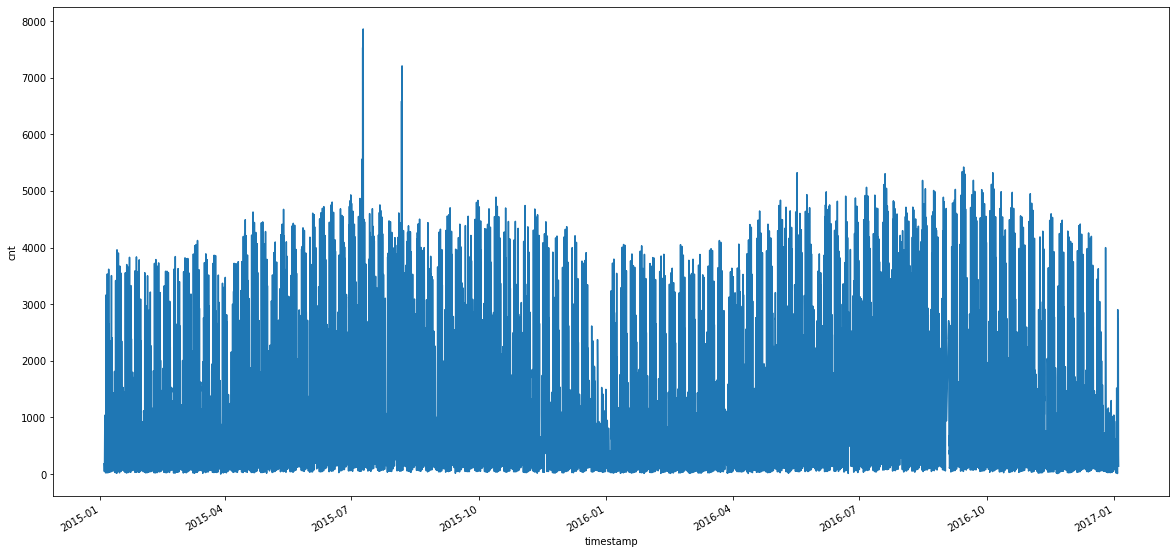

In [8]:
%matplotlib inline
df['cnt'].plot(figsize=(20,10))
_ = plt.ylabel('cnt')

It is possible to detect some kind of seasonality in the warmer months

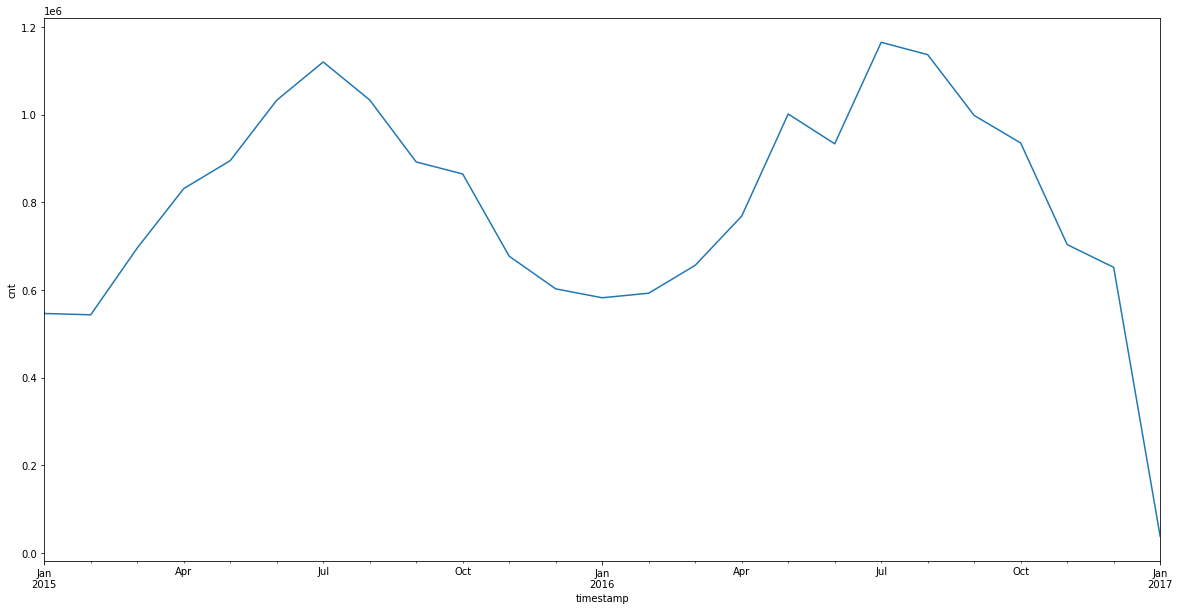

In [9]:
df.resample('M').sum()['cnt'].plot(figsize=(20,10))
_ = plt.ylabel('cnt')

The seasonality is even more clear

# Feature Engineering

In [10]:
df['hour'] = df.index.hour
df['day_of_month'] = df.index.day
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month

In [11]:
df.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,day_of_month,day_of_week,month
timestamp,,,,,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,0,4,6,1
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,1,4,6,1
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2,4,6,1
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,3,4,6,1
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,4,4,6,1


In [12]:
df_hour = df.groupby('hour').sum()

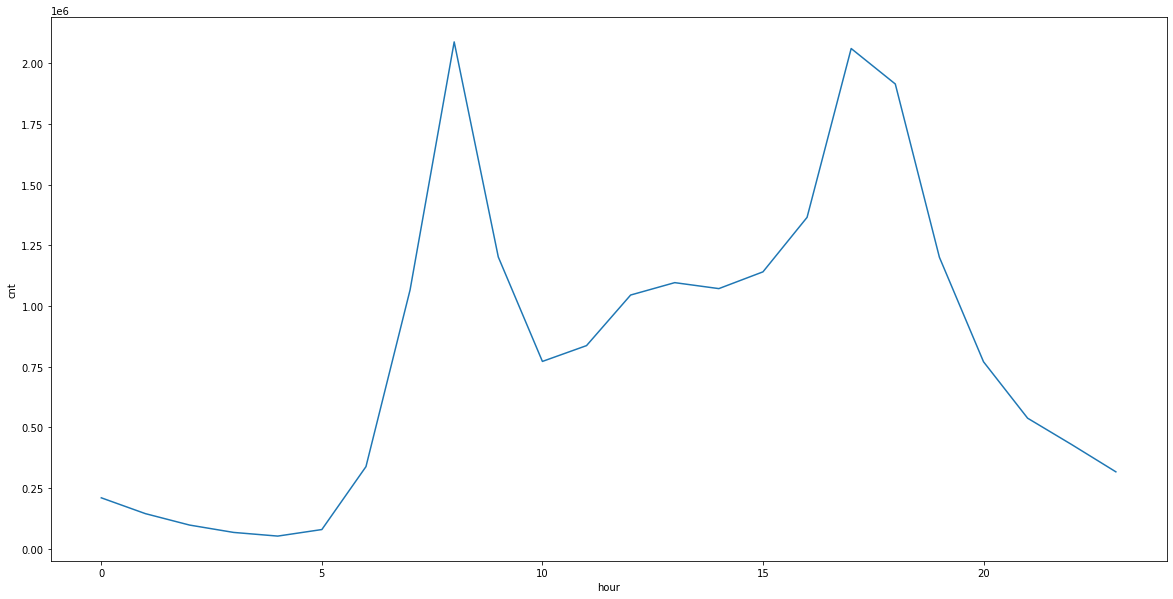

In [13]:
df_hour['cnt'].plot(figsize=(20,10))
_ = plt.ylabel('cnt')

In [14]:
df_hour_is_holiday = df.groupby(['hour', 'is_holiday']).sum()

In [15]:
df_hour_is_holiday = df_hour_is_holiday.reset_index()
df_hour_is_holiday.head()

,hour,is_holiday,cnt,t1,t2,hum,wind_speed,weather_code,is_weekend,season,day_of_month,day_of_week,month
0,0,0.0,204836,7971.000000,7266.500000,55284.25,9859.250000,1895.0,206.0,1058.0,11115,2148,4613
1,0,1.0,5565,166.500000,146.500000,1288.00,243.500000,55.0,0.0,20.0,292,17,100
2,1,0.0,141437,7784.333333,7055.833333,56118.00,9636.833333,1986.0,206.0,1059.0,11119,2148,4617
3,1,1.0,3820,162.500000,142.000000,1296.50,266.000000,56.0,0.0,20.0,292,17,100
4,2,0.0,95782,7588.500000,6834.500000,56578.50,9410.000000,2110.0,204.0,1056.0,11047,2136,4599


# Processing

In [16]:
# 90% 10% split without shufling
train_size = int(len(df) * 0.9)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

15672 1742


In [17]:
f_columns = ['t1', 't2', 'hum', 'wind_speed']


In [18]:

f_transformer = RobustScaler()
cnt_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
cnt_transformer = cnt_transformer.fit(train[['cnt']])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['cnt'] = cnt_transformer.transform(train[['cnt']])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['cnt'] = cnt_transformer.transform(test[['cnt']])

/home/tiagocabo/Documents/privateGit/Time-Series-Exercises/venv/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/tiagocabo/Documents/privateGit/Time-Series-Exercises/venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/tiagocabo/Documents/privateGit/Time-Series-Exercises/venv/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is tryin

In [19]:
# to ease the dataset preparation
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [20]:
time_steps = 10

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.cnt, time_steps)
X_test, y_test = create_dataset(test, test.cnt, time_steps)

print(X_train.shape, y_train.shape)

(15662, 10, 13) (15662,)



# Apply model

In [21]:
X_train.shape

(15662, 10, 13)

In [22]:
# Let's start by using a bidirectional LSTM using dropout layer with adam optimizer
model = Sequential()
model.add(
  Bidirectional(
    LSTM(
      units=128,
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(Dropout(rate=0.2))
model.add(Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [23]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)


Train on 14095 samples, validate on 1567 samples
Epoch 1/30
14095/14095 [==============================] - 6s 407us/step - loss: 0.2642 - val_loss: 0.0959
Epoch 2/30
14095/14095 [==============================] - 5s 384us/step - loss: 0.0696 - val_loss: 0.0516
Epoch 3/30
14095/14095 [==============================] - 6s 397us/step - loss: 0.0452 - val_loss: 0.0474
Epoch 4/30
14095/14095 [==============================] - 5s 353us/step - loss: 0.0387 - val_loss: 0.0332
Epoch 5/30
14095/14095 [==============================] - 6s 423us/step - loss: 0.0324 - val_loss: 0.0331
Epoch 6/30
14095/14095 [==============================] - 6s 420us/step - loss: 0.0291 - val_loss: 0.0365
Epoch 7/30
14095/14095 [==============================] - 6s 436us/step - loss: 0.0266 - val_loss: 0.0333
Epoch 8/30
14095/14095 [==============================] - 6s 448us/step - loss: 0.0241 - val_loss: 0.0317
Epoch 9/30
14095/14095 [==============================] - 6s 444us/step - loss: 0.0230 - val_loss: 0.0

# Model Evaluate

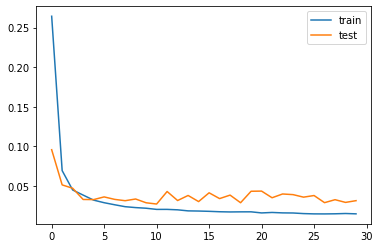

In [24]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [25]:
y_pred = model.predict(X_test)

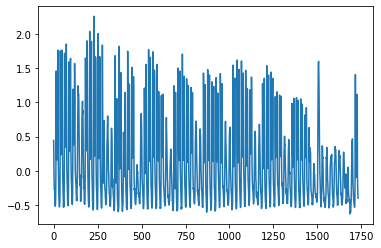

In [26]:
pd.Series(y_pred.flatten()).plot()

In [27]:
y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cnt_transformer.inverse_transform(y_pred)

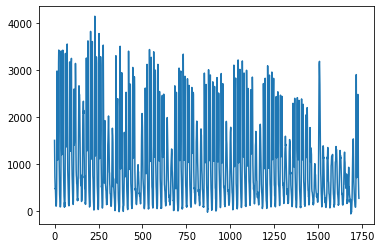

In [28]:
pd.Series(y_pred_inv.flatten()).plot()

In [32]:
 y_train.shape

(15662,)

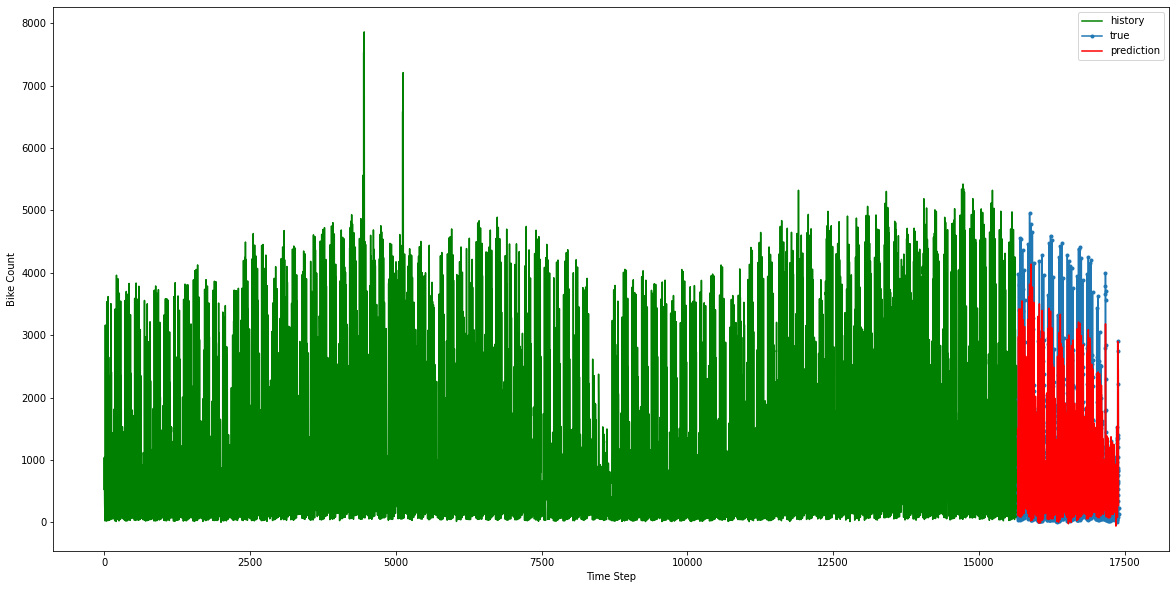

In [34]:
plt.figure(figsize=(20,10))
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

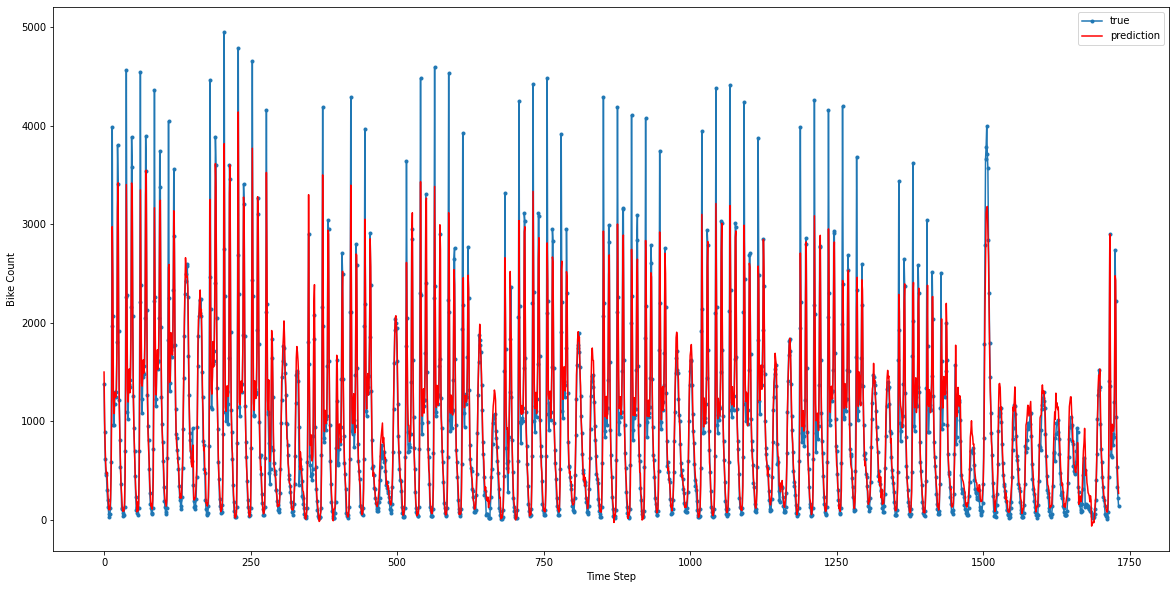

In [37]:
%matplotlib inline
plt.figure(figsize=(20,10))
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

As can be seen the results are pretty accurate.